In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift, fft2, ifft2
from scipy.integrate import simps
from scipy.interpolate import interp2d
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
import numpy.ma as ma
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy.random as rm
import warnings
from PIL import Image
from scipy import ndimage
plt.style.use('notes')

path = '/media/robert/Data_Storage/Data/Experimental/Test_Optic_1/'
lam = 0.796
tau = 30 # RMS pulse length in fs, needs to be updated if optical design changes
L = 30e4 # Distance between optics, needs to be updated if optical design changes
w0 = 15e3 # Radius of the super Gaussian, needs to be updated if optical design changes
plasma_start, plasma_end = np.load(path+'plasma_size.npy')
# All length units are in um

In [2]:
# Load the lens phase patterns from a file
# Create the first lens
Nx = 2**12 # These will be overwritten by the saved versions
X = 40e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensA',
              'lam' : lam,
              'load' : True}

lensA = optic.Phase(lensParams)

# Create the second lens
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensB',
              'lam' : lam,
              'load' : True}

lensB = optic.Phase(lensParams)
phiB = interp2d(lensB.x, lensB.y, lensB.phi, 'cubic', bounds_error=False, fill_value=0.0)

# Create a generic initial beam so we can use the member methods
Nx0 = lensA.Nx
X0 = lensA.X
beamParams = {'Nx' : Nx0,
              'Ny' : Nx0,
              'X' : X0,
              'Y' : X0,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_Generic',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam0 = laserbeam.Laser(beamParams)
E = np.load(path+'initial_E.npy')
r = np.load(path+'initial_r.npy')
path2 = path + 'Diffractive/'
e = beam0.reconstruct_from_cyl(r, E, beam0.x, beam0.y)
beam0.initialize_field(e)
interactions.beam_phase(beam0, lensA)
# Propagate the initial beam through lens A to get the initial field at lens B
# Set the initial field for all the subsequent simulations
beam0.propagate(L, 1.0)

# Length from the second lens to the start of the plasma
L2 = plasma_start

In [3]:
# The maximum Feature depth in 3-4 um corresponding to a phase difference of about 2-2.75 rad
# Step sizes of 80 nm possible
# Pixel size is 2um wide
# For our incoming beam on a 34mm optic this corresponds to 17,000 pixels
# Let's just start with the number of pixels and go from there
# w is the number of phase wraps, 1 means the total height of the etch gives 2pi phase
# Layers is the discretization of the etch
def create_lens(Nx, w=1, layers=10):
    X = 20e3
    lensParams = {'Nx' : Nx,
                  'Ny' : Nx,
                  'X' : X,
                  'Y' : X,
                  'path' : path,
                  'name' : 'LensBD',
                  'lam' : lam,
                  'load' : False}
    lensBD = optic.Phase(lensParams)
    phi = phiB(lensBD.x, lensBD.y)
    phi -= np.amin(phi)
    phi = phi % (w*2*np.pi)
    phi = np.floor(phi * layers / (w*2*np.pi))*w*2*np.pi/layers
    lensBD.initialize_phase(phi)
    return lensBD

# This function will run at 4 times the passed grid size to see higher order diffraction
def diffraction_lens(Nx, w=1, layers=10):
    lens = create_lens(Nx, w, layers)
    Nx = 4*lens.Nx
    X = 2*lens.X
    lensParams = {'Nx' : Nx,
                  'Ny' : Nx,
                  'X' : X,
                  'Y' : X,
                  'path' : path,
                  'name' : 'LensBD_D',
                  'lam' : lam,
                  'load' : False}
    lens2 = optic.Phase(lensParams)
    phi = np.zeros((Nx, Nx), dtype='double')+lens.phi[0, 0]
    k = int(Nx/4)
    phi[k:3*k, k:3*k] = ndimage.zoom(lens.phi, 2, order=0)
    lens2.initialize_phase(phi)
    return lens2

In [4]:
# Save a plot of the phase mask
def plot_phase_image(lens, filename):
    phi = lens.phi
    ext = -lens.X/2e3

    plt.figure(figsize=(4, 3), dpi=1800)
    plt.imshow(phi, extent=[-ext, ext, -ext, ext], interpolation='nearest')
    cb = plt.colorbar()
    cb.set_label(r'$\phi$ (rad)')
    plt.xlabel(r'x (mm)')
    plt.ylabel(r'y (mm)')
    plt.savefig(filename)
    plt.clf()

In [5]:
# Propagate a beam through a phase element
def propagate_beam(lens, length=L2):
    Nx = lens.Nx
    X = lens.X
    beamParams = {'Nx' : Nx,
                  'Ny' : Nx,
                  'X' : X,
                  'Y' : X,
                  'lam' : lam,
                  'path' : path2,
                  'name' : 'Beam1_A_to_B',
                  'threads' : 4,
                  'cyl' : True,
                  'load' : False}

    beam1 = laserbeam.Laser(beamParams)
    e = beam1.rescale_field(beam0, beam1)
    beam1.initialize_field(e)
    interactions.beam_phase(beam1, lens)
    beam1.propagate(length, 1.0)
    return beam1

# Get the radial electric field and radius vector
def get_radial_field(beam1):
    r1 = -beam1.x[:int(beam1.Nx/2+1)]
    e1 = beam1.e[:int(beam1.Nx/2+1), int(beam1.Ny/2+1)]
    return r1, e1

# Plot the laser at the second optic
def plot_intensity(beam):
    I = beam.intensity_from_field(beam.e)
    I = beam.prep_data(I)
    ext = -beam.X/2e3
    plt.figure(figsize=(4, 3), dpi=150)
    plt.imshow(I, aspect='equal', extent=[-ext, ext, -ext, ext], vmin=0.0, vmax=0.082)
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel(r'x (mm)')
    plt.show()

# Calculate the power of the beam within a certain radius
# Used for finding the diffraction efficiency
def calculate_power(beam, ind_max):
    ind = int(beam.Nx/2) + ind_max
    P = beam.total_cyl_power(beam.x[int(beam.Nx/2):ind],
                              beam.intensity_from_field(beam.e[int(beam.Nx/2):ind, int(beam.Nx/2+1)]))
    return P

In [6]:
def plot_field_layers(maxInd):
    print('Diffraction efficiency')
    print(layers)
    print(power/P0)

    rlim = (0, 5)
    plt.figure(figsize=(8, 3), dpi=150)
    ax1 = plt.subplot(121)
    colors = [plt.cm.cool(i) for i in np.linspace(0, 1, N)]
    ax1.set_prop_cycle('color', colors)
    for i in range(N):
        plt.plot(radius[i]/1e3, ionization.intensity_from_field(fields[i]), label=str(layers[i]))
    plt.plot(r_base/1e3, ionization.intensity_from_field(e_base), 'b--', label='Target')
    plt.xlabel(r'z (mm)')
    plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
    plt.xlim(rlim)
    plt.ylim(0, 0.3)
    ax2 = plt.subplot(122)
    ax2.set_prop_cycle('color', colors)
    for i in range(N):
        plt.plot(radius[i]/1e3, np.unwrap(np.angle(fields[i]))
                 -np.amax(np.unwrap(np.angle(fields[i]))[int(maxInd):]),
                 label=str(layers[i]))
    plt.plot(r_base/1e3, np.unwrap(np.angle(e_base))-np.amax(np.unwrap(np.angle(e_base))), 'b--')
    plt.xlabel(r'z (mm)')
    plt.ylabel(r'$\phi$ (radians)')
    plt.xlim(rlim)
    plt.ylim(-80, 10)
    plt.legend(title='layers')
    plt.tight_layout()
    plt.show()

In [7]:
# Calculate the initial power in the beam for diffraction efficency
P0 = calculate_power(beam0, int(beam0.Nx/2))
beam1 = propagate_beam(lensB)
r_base, e_base = get_radial_field(beam1)
print('Peak power %0.2f' % (P0))

Peak power 3.95


In [17]:
# Various layers with 2048 pixels in each direction
layers = np.array([6, 8, 10, 12])
N = len(layers)
fields = {}
radius = {}
power = np.zeros(len(layers))
Nx = 2**11

for i in range(N):
    lens = diffraction_lens(Nx, layers=layers[i])
    beam = propagate_beam(lens)
    r_b, e_b = get_radial_field(beam)
    radius[i] = r_b
    fields[i] = e_b
    power[i] = calculate_power(beam, int(beam.Nx/8))

Diffraction efficiency
[ 6  8 10 12]
[0.80956675 0.83769958 0.85110433 0.86560731]


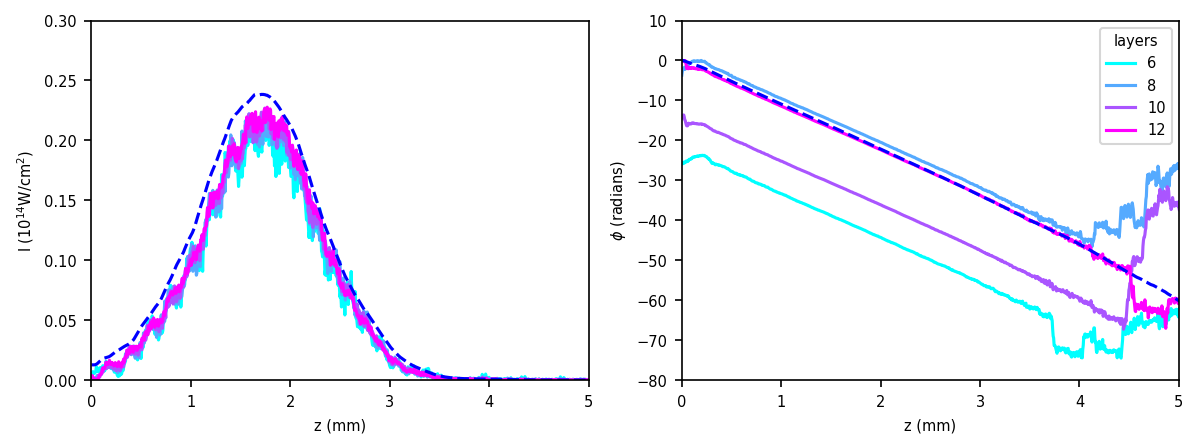

In [18]:
plot_field_layers(1.5*Nx)

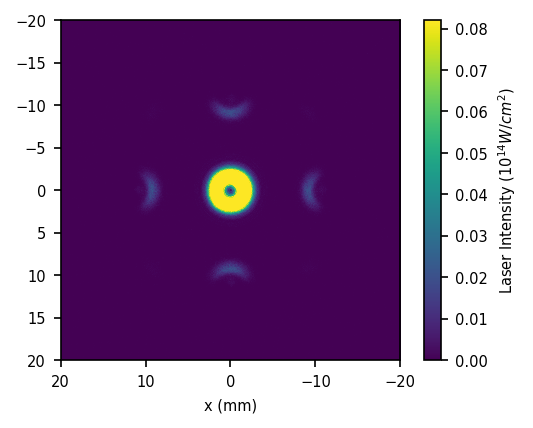

In [10]:
# This phase mask looks fine, but I still want to see the higher order diffraction peaks
lens = create_lens(2**11, layers=10)
plot_phase_image(lens, '2pi10layer_2048X2048_B.png')
lens = diffraction_lens(2**11, layers=10)
beam = propagate_beam(lens)
plot_intensity(beam)

In [11]:
# Various layers with 4096 pixels in each direction
layers = np.array([6, 8, 10, 12])
N = len(layers)
fields = {}
radius = {}
power = np.zeros(len(layers))
Nx = 2**12

for i in range(N):
    lens = create_lens(Nx, layers=layers[i])
    beam = propagate_beam(lens)
    r_b, e_b = get_radial_field(beam)
    radius[i] = r_b
    fields[i] = e_b
    power[i] = calculate_power(beam, int(beam.Nx/4))

Diffraction efficiency
[ 6  8 10 12]
[0.90386    0.93415142 0.94009699 0.95489537]


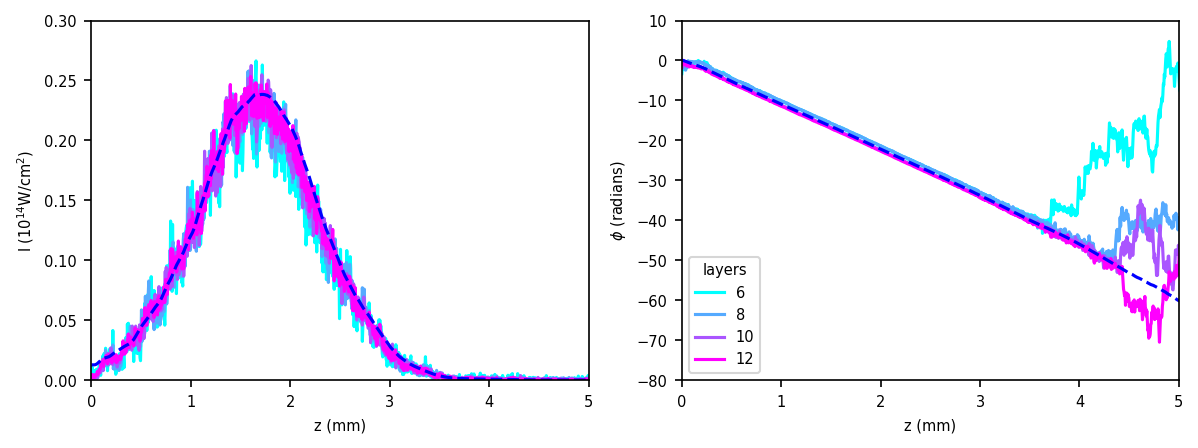

In [12]:
plot_field_layers(Nx/3)

In [13]:
# Various layers with 8192 pixels in each direction
layers = np.array([6, 8, 10, 12])
N = len(layers)
fields = {}
radius = {}
power = np.zeros(len(layers))
Nx = 2**13

for i in range(N):
    lens = create_lens(Nx, layers=layers[i])
    beam = propagate_beam(lens)
    r_b, e_b = get_radial_field(beam)
    radius[i] = r_b
    fields[i] = e_b
    power[i] = calculate_power(beam, int(beam.Nx/4))

Diffraction efficiency
[ 6  8 10 12]
[0.90544639 0.92735714 0.94208139 0.95009314]


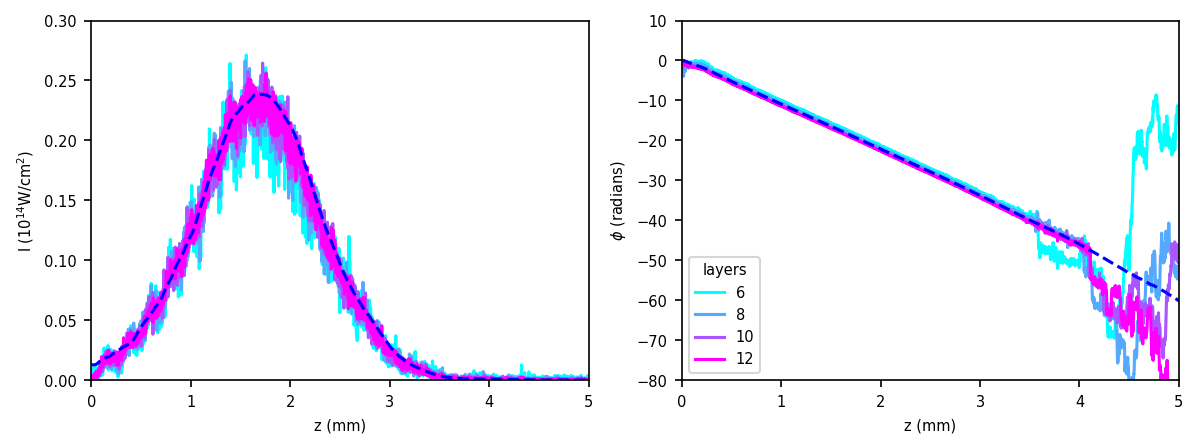

In [14]:
plot_field_layers(Nx/3)